![image](google-header.png)

## **Google Search Analysis: EDA**


### **Recap...**
So...in the previous workbook we explored getting the data from Google...Cool! Lets take things a step further and see if we can start to understand the results, population, do some feature engineerings, and prepare to do some modeling in the next step.

## **Overview**
The following cells will do some data exploration, basic cleanup, some feature engineering, and then clustering and text analysis.

In [86]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

RAW_DATA = 'data'

#### **Import Data**

In [4]:
search_results = pd.read_csv(Path(RAW_DATA).joinpath('search_results.csv'), delimiter='\t')
search_results.head()

,title,link,displayLink,snippet,cacheId,formattedUrl,pagemap
0,Where We're at with Vaccines and Treatments fo...,https://www.healthline.com/health-news/heres-e...,www.healthline.com,3 days ago ... Scientists around the world are...,3ipdFSvg4JEJ,https://www.healthline.com/.../heres-exactly-w...,{'cse_thumbnail': [{'src': 'https://encrypted-...
1,Pfizer: COVID-19 Vaccine Could Arrive in October,https://www.webmd.com/lung/news/20200515/pfize...,www.webmd.com,"May 15, 2020 ... Pharmaceutical company Pfizer...",x2ZnEeIQudkJ,https://www.webmd.com/.../pfizer-says-covid-19...,{'cse_thumbnail': [{'src': 'https://encrypted-...
2,What you need to know about the COVID-19 vacci...,https://www.gatesnotes.com/Health/What-you-nee...,www.gatesnotes.com,"Apr 30, 2020 ... How do you store it? Many com...",NaN,https://www.gatesnotes.com/.../What-you-need-t...,{'cse_thumbnail': [{'src': 'https://encrypted-...
3,COVID-19 vaccine tracker | RAPS,https://www.raps.org/news-and-articles/news-ar...,www.raps.org,This tracker lists COVID-19 vaccine candidates...,sB1XCTgmPtsJ,https://www.raps.org/news-and-articles/news......,{'cse_thumbnail': [{'src': 'https://encrypted-...
4,Trump unveils audacious plan to develop Covid-...,https://www.statnews.com/2020/05/15/trump-auda...,www.statnews.com,"May 15, 2020 ... Trump administration outlines...",lGEf1Nfgz0oJ,https://www.statnews.com/2020/05/.../trump-aud...,"{'hcard': [{'fn': 'Dan', 'nickname': 'Dan'}, {..."


In [5]:
search_terms = pd.read_csv(Path(RAW_DATA).joinpath('search_terms.csv'),delimiter='\t')
search_terms.head()

,title,totalResults,searchTerms
0,Google Custom Search - covid-19 vaccines,173000000,covid-19 vaccines


#### **Vecotrize Search Result Titles**
Perform very basic text processing for baseline KMeans application

In [83]:
# Get text snippets from search results dataframe
snippets_text = search_results['title']

vectorizer = TfidfVectorizer(stop_words='english')

X = vectorizer.fit_transform(snippets_text)

#### **Determine KMeans Clusters**

In [87]:
inertias = []

KMEANS_MAX = range(2,30,2)

for k in KMEANS_MAX:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    model.fit_predict(X)
    inertias.append(model.inertia_)

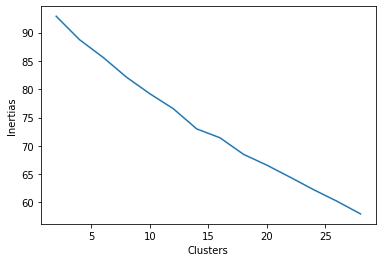

In [88]:
model_selection = pd.DataFrame({'Inertias': inertias, 'Clusters': KMEANS_MAX})
sns.lineplot(x=model_selection['Clusters'], y=model_selection['Inertias'])

##### **KMeans Interpretation**

The above Inertia plot is not very useful. Even with expansion of clusters the model is having trouble finding clusters of similarities. It is most likely due to very basic preprocessing step, or the fact that we had a very specific search, there truly is only "1" cluster. To improve the clustering, I would spend greater time on text pre-processing and introduce some other topics to see how the cluster performs. 

Specifically, the numbers 19 seem to be detracting from clustering ability since it appears in almost every title.

#### **Model Selection**
As noted above, there is not a elbow in above inertia plot indicating difficulty in clustering these article titles. For this example case, we wil go with 15 clusters to get good performance and prove further clustering techniques

In [100]:
model = KMeans(n_clusters=15, init='k-means++', max_iter=100)
model.fit_predict(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()

clusters_tmp = []
for i in range(0,15):
    cluster = {'cluster': 'Cluster '+str(i),
               'keywords': [terms[ind] for ind in order_centroids[i, :5]]}
    clusters_tmp.append(cluster)
    
keywords = pd.DataFrame(clusters_tmp)
keywords = keywords.explode('keywords')
keywords.head(50)

,cluster,keywords
0,Cluster 0,tracker
0,Cluster 0,raps
0,Cluster 0,19
0,Cluster 0,covid
0,Cluster 0,vaccine
1,Cluster 1,coronavirus
1,Cluster 1,vaccine
1,Cluster 1,harvard
1,Cluster 1,bbc
1,Cluster 1,news
